In [13]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
import scipy.optimize as so
from scipy.interpolate import interp1d

# from jupyter_server import serverapp as app; 
# import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [14]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [15]:
import analysis.mathematical_functions.funcs as funcs

In [16]:
data_folder = project_path+'/data/parameter_runs/many_kappas/'
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files if f.endswith('_feather')]
dataframes = [pd.read_feather(f) for f in data_files]

In [17]:
data_files

['../data/parameter_runs/many_kappas//01-10-19--04-06-2023abm_result_feather']

In [18]:
if len(dataframes)==1:
    datadf = dataframes[0]

In [19]:
datadf['first_tb'].unique()

array([29.47310585, 20.68064554,         inf, ..., 10.84717367,
        5.99631146,  3.10555556])

In [20]:

@jit(nopython=True)
def p_surv(fit,t_lim,dt,reg= 1e-3):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv
            

def product_sum_probas(S,I, t_lim, R0, kappa,xi,ds,dt, N, p_alpha):
    x,y = S/N, I/N
    z = 1-x-y
    
    fit_d = lambda d: R0/(1+y*kappa) * ( x + (1- np.exp(-d/xi))*z )-1

    product_sum = 0
    
    L = len(ds)
    for i in range(L):
        d= ds[i]
        fit = fit_d(d)
        p_surv_t = p_surv(fit,t_lim, dt)
        product_sum +=funcs.rho_d(d=d,p_alpha=p_alpha )*p_surv_t
    
    return product_sum

def product_sum_probas_adiabatic(S,I, t_lim, R0, kappa,xi,ds,dt, N, p_alpha):
    x,y = S/N, I/N
    z = 1-x-y
    
    fit_d = lambda d: R0/(1+y*kappa) * ( x + (1- np.exp(-d/xi))*z )-1

    product_sum = 0
    
    L = len(ds)
    for i in range(L):
        d= ds[i]
        fit = fit_d(d)
        p_surv_t = np.maximum(0,1 - 1/(1+fit))
        product_sum +=funcs.rho_d(d=d,p_alpha=p_alpha )*p_surv_t
    
    return product_sum

In [21]:


def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))

def integrate_trajectory(R0,kappa,N, I0=10):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 3*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,10000)
    dt = ts[1]-ts[0]
    y = odeint(model_w_params(R0,N,kappa),y0,ts).T

    return ts, y

def get_exp_num_established(R0, kappa, p_alpha,xi, N,pbar = None):
    ts, solution= integrate_trajectory(R0,kappa,N)
    ds = np.arange(1,int(10/p_alpha)+1)

    S,I = solution
    t2 = ts[-1]
    dt = ts[1]-ts[0]
    idx_times = ts<t2
    prod_sum_prob = product_sum_probas(S,I, t2, R0, kappa,xi,ds,dt, N, p_alpha)

    try:
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
    except ValueError:
        idx_times = ts<=t2
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
    if pbar is not None:
        pbar.update(1)
    return exp_number_est_mutants

def get_exp_num_established_adiabatic(R0, kappa, p_alpha,xi, N):
    ts, solution= integrate_trajectory(R0,kappa,N)
    ds = np.arange(1,int(10/p_alpha)+1)

    S,I = solution
    t2 = ts[-1]
    dt = ts[1]-ts[0]
    idx_times = ts<t2
    prod_sum_prob = product_sum_probas_adiabatic(S,I, t2, R0, kappa,xi,ds,dt, N, p_alpha)
    try:
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
    except ValueError:
        idx_times = ts<=t2
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
        
    return exp_number_est_mutants

In [22]:
def model_w_params(R0, N, k, control_fun): 
    def model(X,t):
        S = X[0]
        I = X[1]
        y = I/N
        x= S/N

        R0_eff = R0 * control_fun(y,k)
        dSdt = - R0_eff * S*y
        dIdt = I *  (R0_eff * x - 1)
        return [dSdt,dIdt]
    return model

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))

def integrate_trajectory(R0,kappa,N, I0=10, control_fun = lambda y,k: 1/(1+k*y)):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 3*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,10000)
    dt = ts[1]-ts[0]
    X = odeint(model_w_params(R0,N,kappa,control_fun=control_fun),y0,ts).T

    return ts, X

In [23]:
kappa_s = np.logspace(-3,4,100)




fractional_fun = lambda y,k: 1/(1+k*y)
exp_fun = lambda y,k: np.exp(-k*y)
linear_fun = lambda y,k: 1-k*y

control_funs = [fractional_fun, exp_fun, linear_fun]

control_labels = ['Fractional','Exponential','Linear']
control_colors = ['steelblue','darkorange','forestgreen']


N = 1e7 
R0 = 6
dict_yps = {e : [] for e in control_labels}
dict_zinfs = {e : [] for e in control_labels}

for kappa in tqdm(kappa_s):
    for i,control_fun in enumerate(control_funs):
        ts, X = integrate_trajectory(R0,kappa,N, control_fun = control_fun)
        S,I = X
        y = I/N
        x= S/N
        z= 1-x-y
        dict_yps[control_labels[i]].append(np.max(y))
        dict_zinfs[control_labels[i]].append(z[-1])




100%|██████████| 100/100 [00:00<00:00, 313.92it/s]


Text(0, 0.5, '$z_{\\infty}(\\Gamma,R_0) - (1-1/R_0)$')

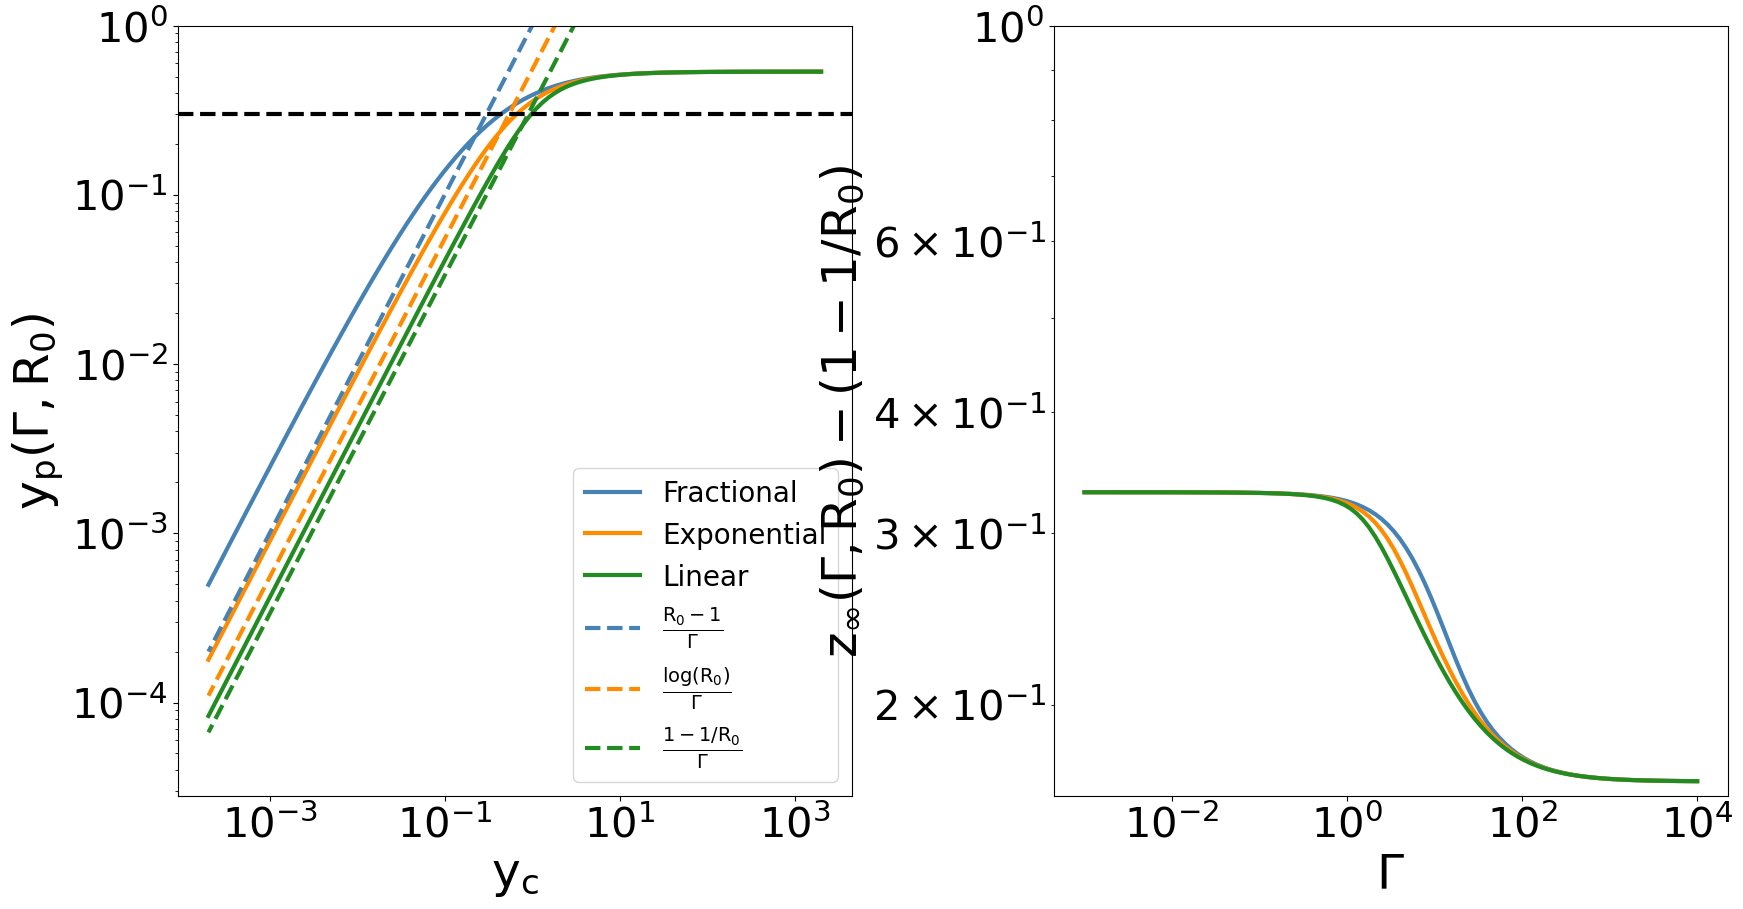

In [32]:

fig, ax = plt.subplots(1,2,figsize=(20,10))
plt.subplots_adjust(wspace=0.3)
for e in control_labels:
    dict_yps[e] = np.array(dict_yps[e])
    ax[0].plot((R0-1)/kappa_s,dict_yps[e],label=e,color=control_colors[control_labels.index(e)])

ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].plot((R0-1)/kappa_s, (R0-1)/kappa_s,color=control_colors[0],linestyle='--',label=r'$\frac{R_0-1}{\Gamma}$')
ax[0].plot((R0-1)/kappa_s, np.log(R0)/kappa_s,color=control_colors[1],linestyle='--',label=r'$\frac{\log(R_0)}{\Gamma}$')
ax[0].plot((R0-1)/kappa_s, (1-1/R0)/kappa_s,color=control_colors[2],linestyle='--',label=r'$\frac{1-1/R_0}{\Gamma}$')

# ax[0].axhline(y=(R0-1-np.log(R0))/R0,linestyle='--',color='black')

# ax[0].axvline(x=R0*(R0-1)/(R0-1-np.log(R0)),linestyle='--',color=control_colors[0])
# ax[0].axvline(R0*np.log(R0)/(R0-1-np.log(R0)),linestyle='--',color=control_colors[1])
# ax[0].axvline(x=(R0-1)/(R0-1-np.log(R0)),linestyle='--',color=control_colors[2])

# ax[0].axvline(x=R0,linestyle='--',color='black')
ax[0].set_ylim(top = 1)
ax[0].set_xlabel(r'$y_c$')
ax[0].set_ylabel(r'$y_p(\Gamma,R_0)$')
ax[0].legend(fontsize=20)

#(1-1/R0*(1- (1-1/R0)**(-1)*yps)) - (1-1/R0) = 
for e in control_labels:
    dict_zinfs[e] = np.array(dict_zinfs[e])
    yps = dict_yps[e]
    ax[1].plot(kappa_s,dict_zinfs[e] - (1-1/R0),label=e,color=control_colors[control_labels.index(e)])
    # ax[1].plot(kappa_s,2*yps/(R0),color=control_colors[control_labels.index(e)],linestyle='--')
# ax[1].plot(kappa_s,1/kappa_s,color='black',linestyle='--',label=r'$\frac{\Gamma}{R_0-1}$')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(top = 1)

ax[1].set_xlabel(r'$\Gamma$')
ax[1].set_ylabel(r'$z_{\infty}(\Gamma,R_0) - (1-1/R_0)$')

In [28]:
R0

3

(0.0, 500.0)

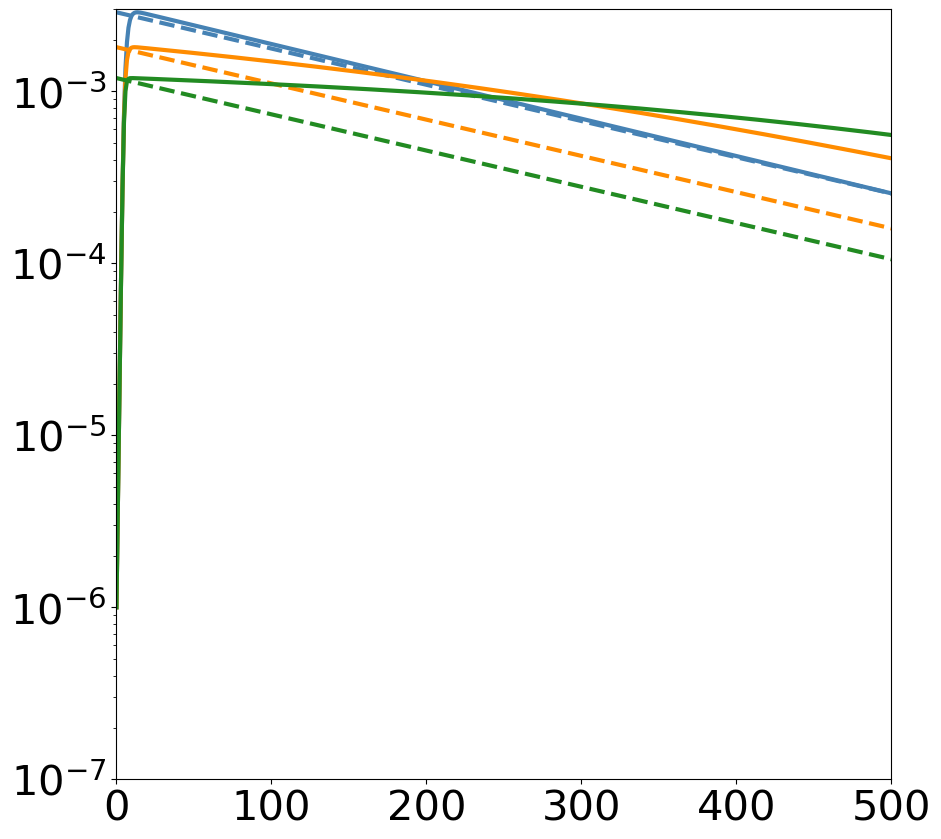

In [25]:
R0, kappa = 2.5, 500

N = 1e7

fig,ax= plt.subplots(1,1,figsize=(10,10))
for control_fun in control_funs:
    ts, X = integrate_trajectory(R0,kappa,N, control_fun = control_fun)
    S,I = X
    y = I/N
    plt.plot(ts,y,label=control_labels[control_funs.index(control_fun)],color =control_colors[control_funs.index(control_fun)])

    tp = ts[np.argmax(y)]
    yp = np.max(y)
    ax.plot(yp*np.exp(-R0/kappa*ts),label=control_labels[control_funs.index(control_fun)],linestyle='--',color =control_colors[control_funs.index(control_fun)])
    ax.axvline(np.log(N)/(2.1*yp)* (1-1/R0+1/kappa),linestyle='--',color =control_colors[control_funs.index(control_fun)])
ax.set_yscale('log')
ax.set_ylim(top = (R0-1)/kappa, bottom=1/N)
ax.set_xlim(right = np.log(N)*kappa/2)


ax.set_xlim(0,500)


100%|██████████| 100/100 [00:00<00:00, 339.80it/s]


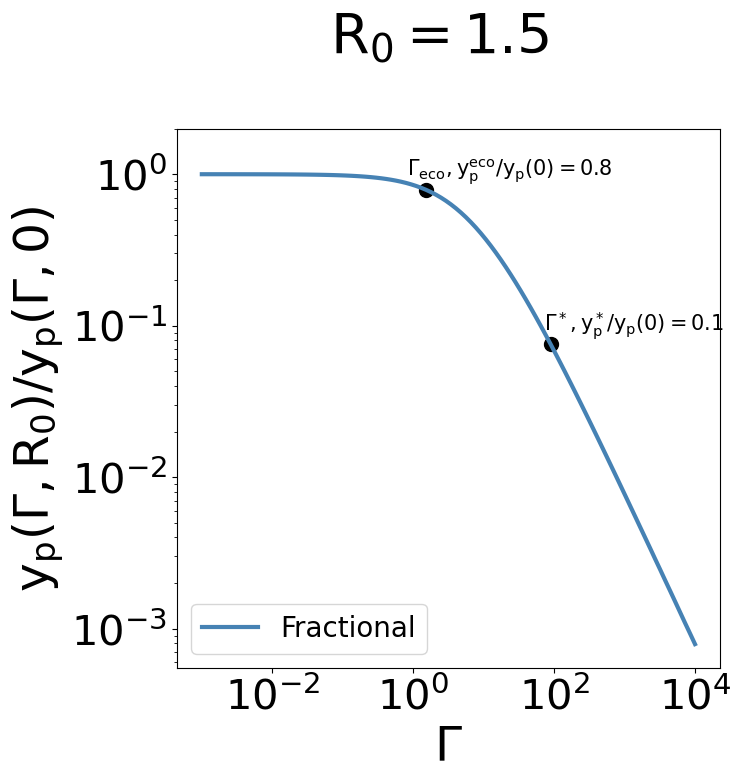

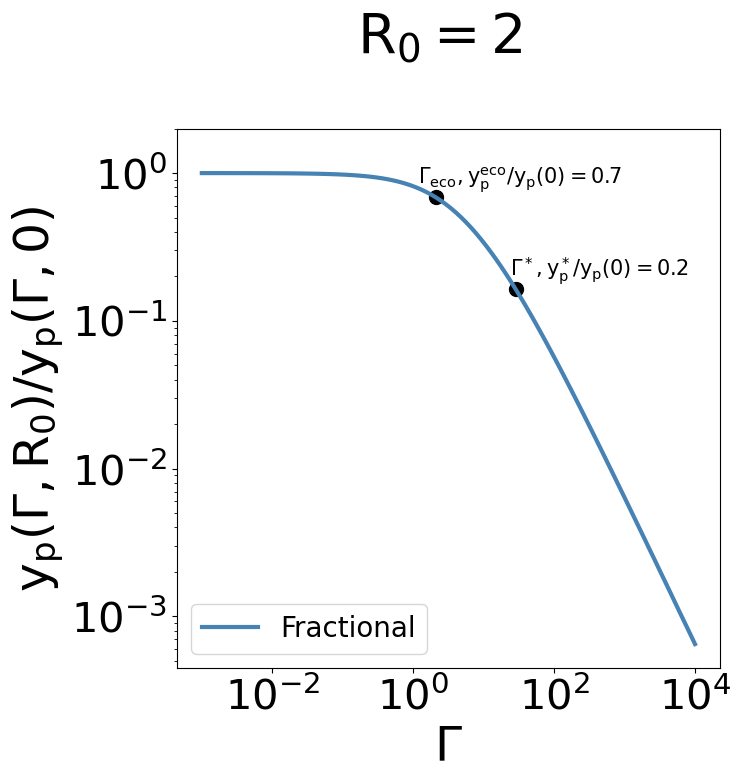

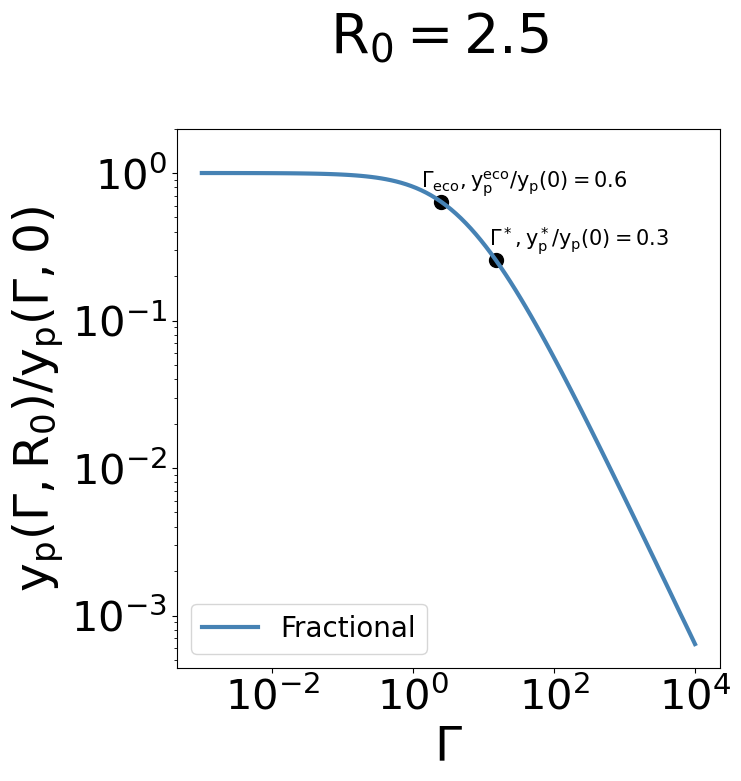

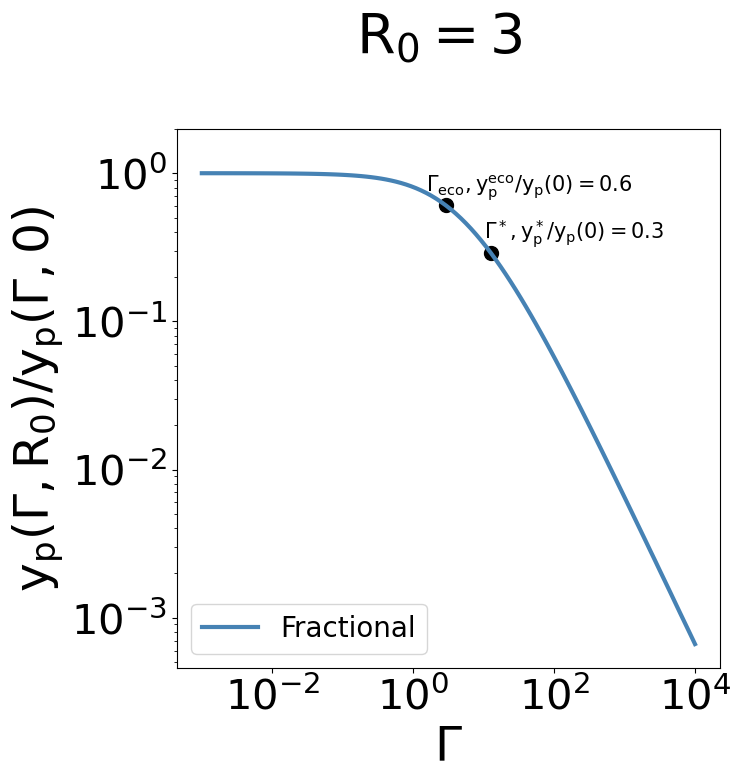

In [80]:

delta = 1/5
N = 1e7 

for R0 in [1.5,2,2.5,3]:
    dict_yps = {e : [] for e in control_labels}
    dict_zinfs = {e : [] for e in control_labels}
    for kappa in tqdm(kappa_s):
        for i,control_fun in enumerate(control_funs):
            ts, X = integrate_trajectory(R0,kappa,N, control_fun = control_fun)
            S,I = X
            y = I/N
            x= S/N
            z= 1-x-y
            dict_yps[control_labels[i]].append(np.max(y))
            dict_zinfs[control_labels[i]].append(z[-1])


    fig, ax = plt.subplots(1,1,figsize=(7,7))
    plt.subplots_adjust(wspace=0.3)
    for e in ['Fractional']:
        dict_yps[e] = np.array(dict_yps[e])
        yps = dict_yps[e]
        ax.plot(kappa_s,yps/yps[0],label=e,color=control_colors[control_labels.index(e)])

    ax.set_xscale('log')
    ax.set_yscale('log')

    gamma_eco = R0
    gamma_star = np.log(2)*1/delta *(R0)**3/((R0-1)**3)

    kappa_star= kappa_s[np.argmin(np.abs(kappa_s-gamma_star))]
    ind_star = np.argmin(np.abs(kappa_s-gamma_star))
    yps_star = dict_yps['Fractional'][ind_star]

    ax.scatter(kappa_star,yps_star/yps[0],color='black',s=100)
    ax.annotate(r'$\Gamma^*,$' + f'$y_p^* /y_p(0) = {yps_star/yps[0]:.1f}$',(2*kappa_star,yps_star/yps[0]),textcoords="offset points",xytext=(45,10),ha='center',fontsize=15)

    gamma_eco = R0
    kappa_eco = kappa_s[np.argmin(np.abs(kappa_s-gamma_eco))]
    ind_eco = np.argmin(np.abs(kappa_s-gamma_eco))
    yps_eco = dict_yps['Fractional'][ind_eco]

    ax.scatter(kappa_eco,yps_eco/yps[0],color='black',s=100)
    ax.annotate(r'$\Gamma_{eco},$' + fr'$y_p^\mathrm{{eco}} /y_p(0) ={yps_eco/yps[0]:.1f}$',(2*kappa_eco,yps_eco/yps[0]),textcoords="offset points",xytext=(45,10),ha='center',fontsize=15)


    # ax.plot((R0-1)/kappa_s, (R0-1)/kappa_s,color=control_colors[0],linestyle='--',label=r'$\frac{R_0-1}{\Gamma}$')
    # ax.plot((R0-1)/kappa_s, np.log(R0)/kappa_s,color=control_colors[1],linestyle='--',label=r'$\frac{\log(R_0)}{\Gamma}$')
    # ax.plot((R0-1)/kappa_s, (1-1/R0)/kappa_s,color=control_colors[2],linestyle='--',label=r'$\frac{1-1/R_0}{\Gamma}$')

    ax.set_xlabel(r'$\Gamma$')

    ax.set_ylim(top = 2)
    ax.set_xlabel(r'$\Gamma$')
    ax.set_ylabel(r'$y_p(\Gamma,R_0)/y_p(\Gamma,0)$')
    ax.legend(fontsize=20,loc='lower left')
    fig.suptitle(f'$R_0 = {R0}$',fontsize=40,y=1.05)

Text(0, 0.5, '$y_p^*$')

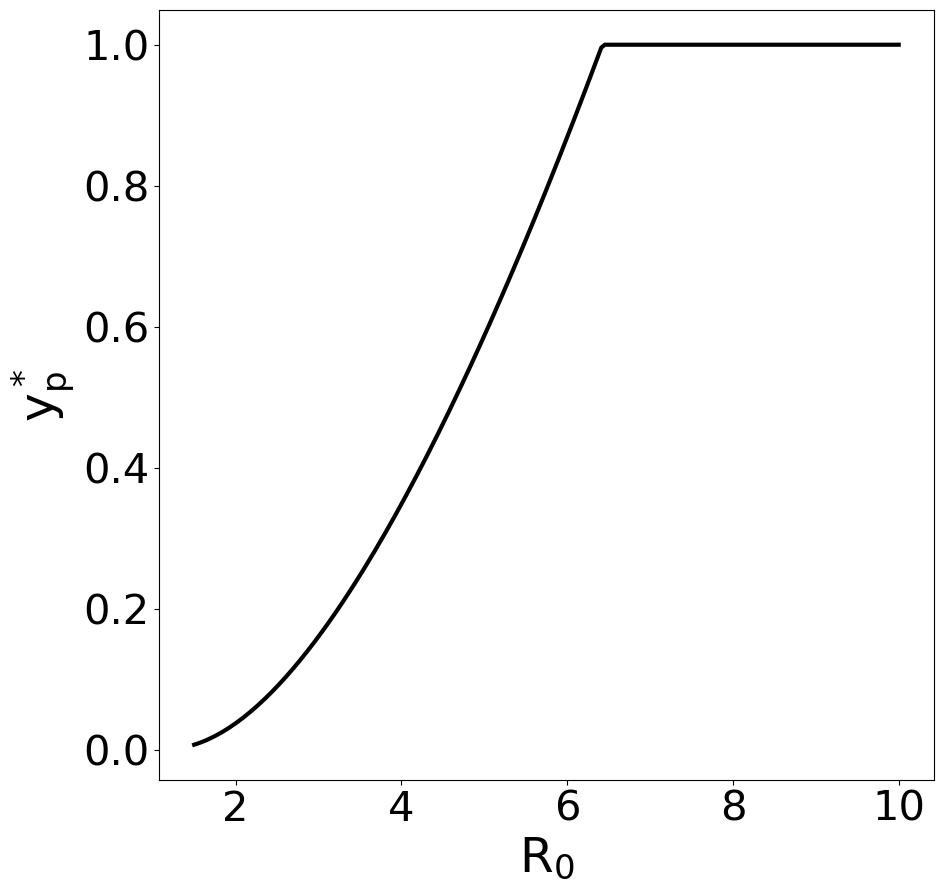

In [89]:
y_star_delta_R0 = lambda delta, R0: np.min((delta * (R0-1)**3/(R0*(np.sqrt(4*R0-1))),1))

R0s = np.linspace(1.5,10,200)
delta = 1/5

fig, ax = plt.subplots(1,1,figsize=(10,10))
ystars  = [ y_star_delta_R0(delta,R0) for R0 in R0s]
ax.plot(R0s,ystars,label=r'$y_p^*$',color='black')

ax.set_xlabel(r'$R_0$')
ax.set_ylabel(r'$y_p^*$')

In [26]:
import numpy as np
R0 = 3

for R0 in [1.5,2,2.5,3]:
    delta = 1/5

    
    y_star = delta * (R0-1)**3/(R0*(np.sqrt(4*R0-1)))
    gamma_star = (R0-1)/y_star

    print(f'R0 = {R0}, y_star = {y_star:.1e}',f'gamma_star = {gamma_star:.1e}')

R0 = 1.5, y_star = 7.5e-03 gamma_star = 6.7e+01
R0 = 2, y_star = 3.8e-02 gamma_star = 2.6e+01
R0 = 2.5, y_star = 9.0e-02 gamma_star = 1.7e+01
R0 = 3, y_star = 1.6e-01 gamma_star = 1.2e+01


In [27]:
import numpy as np
R0 = 3

for R0 in [1.5,2,2.5,3]:
    delta = 1/5
    
    gamma_star = np.log(2)*1/delta *(R0)**3/((R0-1)**3)
    y_star = (R0-1)/gamma_star
    print(f'R0 = {R0}, y_star = {y_star:.1e}',f'gamma_star = {gamma_star:.1e}')

R0 = 1.5, y_star = 5.3e-03 gamma_star = 9.4e+01
R0 = 2, y_star = 3.6e-02 gamma_star = 2.8e+01
R0 = 2.5, y_star = 9.3e-02 gamma_star = 1.6e+01
R0 = 3, y_star = 1.7e-01 gamma_star = 1.2e+01
